# Libraries

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
library(ggtree)
library(ggstance)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


R[write to console]: Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

R[write to console]: ggtree v3.2.1  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution. 2018, 35(12):3041-3043. doi:10.1093/molbev/msy194
3. Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam. ggtree: an R package for visualization and annotation of phylogenetic trees with their covariates and other associated data. Methods in Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628



R[write to console]: 
Attaching package: ‘ggtree’


R[write to conso

In [3]:
%%R
all_best_hits <- read_csv("data/Enterobacteriales_hits_with_species_data.csv")

all_best_hits

New names:
• `` -> `...1`
Rows: 34611 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): qseqid, sseqid, component, cinful_id, pephash, accession, ID2, con...
dbl (14): ...1, pident, length, mismatch, gapopen, qstart, qend, sstart, sen...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 34,611 × 28
    ...1 qseqid   sseqid pident length misma…¹ gapopen qstart  qend sstart  send
   <dbl> <chr>    <chr>   <dbl>  <dbl>   <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1     1 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 2     2 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 3     3 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 4     4 v1_PLS_… H47_s…   56.2     16       7       

In [4]:
%%R
all_best_hits %>%
	count(accession)

# A tibble: 7,963 × 2
   accession           n
   <chr>           <int>
 1 GCA_000168075.1     9
 2 GCA_000214745.2     3
 3 GCA_000240805.2     2
 4 GCA_000250435.2     5
 5 GCA_000264705.1     2
 6 GCA_000268105.1     2
 7 GCA_000316155.1     2
 8 GCA_000319535.1     1
 9 GCA_000319555.1     1
10 GCA_000319595.1     2
# … with 7,953 more rows
# ℹ Use `print(n = ...)` to see more rows


In [5]:
%%R 
Enterobacteriaciae_species_tree <- read.tree("data/Enterobacteriaciae_species.tree")

In [6]:
%%R
samples <- read.csv("data/Enterobacteriales_accessions.csv", header = TRUE)

head(samples)

  X       accession                   added
1 1 GCA_000168075.1 _ASM16807v1_genomic.fna
2 2 GCA_000214745.2 _ASM21474v2_genomic.fna
3 3 GCA_000240805.2 _ASM24080v2_genomic.fna
4 4 GCA_000250435.2 _ASM25043v2_genomic.fna
5 5 GCA_000264705.1 _EntClo_1.0_genomic.fna
6 6 GCA_000268105.1 _ASM26810v1_genomic.fna
                                                       ncbi_organism_name
1                                               Shigella dysenteriae 1012
2                                              Cronobacter sakazakii E899
3 Salmonella enterica subsp. enterica serovar Montevideo str. CT_02035278
4                                                 Escherichia coli DEC14B
5                                 Enterobacter cloacae subsp. cloacae GS1
6                                             Shigella dysenteriae 225-75
                                                                                                                                 ncbi_taxonomy
1                         d__Ba

In [7]:
%%R
samples %>%
separate(gtdb_taxonomy, c('f1','f2','f3','f4','f5','f6','f7','f8'), sep = "__") %>%
	count(f2,f3)

           f2                  f3    n
1 Bacteria; p Actinobacteriota; c    6
2 Bacteria; p Campylobacterota; c   42
3 Bacteria; p     Firmicutes_A; c    4
4 Bacteria; p       Firmicutes; c    2
5 Bacteria; p   Proteobacteria; c 7988
6 Bacteria; p    Spirochaetota; c    1
7        <NA>                <NA>    1


In [8]:
%%R 
testing1 <- samples %>%
separate(gtdb_taxonomy, c('f1','f2','f3','f4','f5','f6','f7','f8'), sep = "__")

testing1$f8 <- gsub('_.','',testing1$f8)


testing1 %>% 
    count(f8)

                                   f8   n
1                Actinomyces marmotae   5
2           Anaerotruncus colihominis   1
3             Atlantibacter hermannii  29
4              Brachyspira pilosicoli   1
5                  Campylobacter coli  40
6            Citrobacter amalonaticus  64
7                 Citrobacter braakii 126
8                  Citrobacter koseri 109
9               Citrobacter werkmanii  65
10                Citrobacter youngae  40
11             Cronobacter condimenti   3
12            Cronobacter dublinensis  42
13            Cronobacter malonaticus  62
14             Cronobacter muytjensii   8
15              Cronobacter sakazakii 437
16            Cronobacter universalis   4
17              Enterobacter asburiae 107
18          Enterobacter cancerogenus  16
19               Enterobacter cloacae 244
20            Enterobacter hormaechei 984
21                 Enterobacter kobei 141
22              Enterobacter ludwigii  86
23                  Enterobacter m

In [9]:
%%R -o speciesAssemblies

speciesAssemblies <- samples %>%
separate(gtdb_taxonomy, c('f1','f2','f3','f4','f5','f6','f7','f8'), sep = "__") %>%
    mutate(f7 = gsub('_.','',f7)) %>%
    mutate(f7 = gsub('; s','',f7)) %>%
    mutate(f8 = gsub('_.','',f8)) %>%
#	filter(f4 == "Enterobacteriaceae_gtdb") %>%
#	filter(f5 != "other_families") %>%
	count(f7,f8) %>%
	rename(clade = f7, species = f8, assemblies = n)

In [10]:
speciesAssemblies

,clade,species,assemblies
1,Actinomyces,Actinomyces marmotae,5
2,Anaerotruncus,Anaerotruncus colihominis,1
3,Atlantibacter,Atlantibacter hermannii,29
4,Brachyspira,Brachyspira pilosicoli,1
5,Campylobacter,Campylobacter coli,40
6,Citrobacter,Citrobacter amalonaticus,64
7,Citrobacter,Citrobacter braakii,126
8,Citrobacter,Citrobacter koseri,109
9,Citrobacter,Citrobacter werkmanii,65
10,Citrobacter,Citrobacter youngae,40


In [11]:
%%R
all_best_hits %>%
	select(gtdb_taxonomy) %>%
    separate(gtdb_taxonomy, c('f1','f2','f3','f4','f5','f6','f7','f8'), sep = "__") %>%
    mutate(f7 = gsub('_.','',f7)) %>%
    mutate(f7 = gsub('; s','',f7)) %>%
    mutate(f8 = gsub('_.','',f8))

# A tibble: 34,611 × 8
   f1    f2          f3                f4                f5    f6    f7    f8   
   <chr> <chr>       <chr>             <chr>             <chr> <chr> <chr> <chr>
 1 d     Bacteria; p Proteobacteria; c Gammaproteobacte… Ente… Ente… Kleb… Kleb…
 2 d     Bacteria; p Proteobacteria; c Gammaproteobacte… Ente… Ente… Kleb… Kleb…
 3 d     Bacteria; p Proteobacteria; c Gammaproteobacte… Ente… Ente… Kleb… Kleb…
 4 d     Bacteria; p Proteobacteria; c Gammaproteobacte… Ente… Ente… Kleb… Kleb…
 5 d     Bacteria; p Proteobacteria; c Gammaproteobacte… Ente… Ente… Kleb… Kleb…
 6 d     Bacteria; p Proteobacteria; c Gammaproteobacte… Ente… Ente… Kleb… Kleb…
 7 d     Bacteria; p Proteobacteria; c Gammaproteobacte… Ente… Ente… Kleb… Kleb…
 8 d     Bacteria; p Proteobacteria; c Gammaproteobacte… Ente… Ente… Kleb… Kleb…
 9 d     Bacteria; p Proteobacteria; c Gammaproteobacte… Ente… Ente… Kleb… Kleb…
10 d     Bacteria; p Proteobacteria; c Gammaproteobacte… Ente… Ente… Kleb… Kleb…
# … w

In [12]:
%%R
Enterobacteriaceae_best_hits <- all_best_hits %>%
    separate(gtdb_taxonomy, c('f1','f2','f3','f4','f5','f6','f7','f8'), sep = "__") %>%
    mutate(f7 = gsub('_.','',f7)) %>%
    mutate(f7 = gsub('; s','',f7)) %>%
    mutate(f8 = gsub('_.','',f8)) %>%
    rename(clade = f7, species = f8)
Enterobacteriaceae_best_hits

# A tibble: 34,611 × 35
    ...1 qseqid   sseqid pident length misma…¹ gapopen qstart  qend sstart  send
   <dbl> <chr>    <chr>   <dbl>  <dbl>   <dbl>   <dbl>  <dbl> <dbl>  <dbl> <dbl>
 1     1 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 2     2 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 3     3 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 4     4 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 5     5 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 6     6 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 7     7 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 8     8 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
 9     9 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
10    10 v1_PLS_… H47_s…   56.2     16       7       0      1    16      1    16
# … 

In [13]:
%%R
Enterobacteriaceae_best_hits %>%
    filter(component == "microcins.verified") %>%
    count(species, name = "n_microcins", )


# A tibble: 46 × 2
   species                   n_microcins
   <chr>                           <int>
 1 Actinomyces marmotae                5
 2 Anaerotruncus colihominis           1
 3 Atlantibacter hermannii             2
 4 Brachyspira pilosicoli              1
 5 Campylobacter coli                  1
 6 Citrobacter amalonaticus            9
 7 Citrobacter braakii                12
 8 Citrobacter koseri                  3
 9 Citrobacter werkmanii               4
10 Citrobacter youngae                 4
# … with 36 more rows
# ℹ Use `print(n = ...)` to see more rows


In [14]:
%%R
species_microcins <- Enterobacteriaceae_best_hits %>%
	filter(component == "microcins.verified") %>%
	count(species, accession) %>% 
	count(species, name = "n_microcins") %>%
	full_join(speciesAssemblies) %>%
	mutate(percent_microcin = n_microcins / assemblies) %>%
    mutate(percent_microcin = gsub("NA","0",percent_microcin))

species_microcins

Joining, by = "species"
# A tibble: 54 × 5
   species                   n_microcins clade         assemblies percent_micr…¹
   <chr>                           <int> <chr>              <int> <chr>         
 1 Actinomyces marmotae                5 Actinomyces            5 1             
 2 Anaerotruncus colihominis           1 Anaerotruncus          1 1             
 3 Atlantibacter hermannii             2 Atlantibacter         29 0.06896551724…
 4 Brachyspira pilosicoli              1 Brachyspira            1 1             
 5 Campylobacter coli                  1 Campylobacter         40 0.025         
 6 Citrobacter amalonaticus            9 Citrobacter           64 0.140625      
 7 Citrobacter braakii                11 Citrobacter          126 0.08730158730…
 8 Citrobacter koseri                  3 Citrobacter          109 0.02752293577…
 9 Citrobacter werkmanii               4 Citrobacter           65 0.06153846153…
10 Citrobacter youngae                 4 Citrobacter           40 

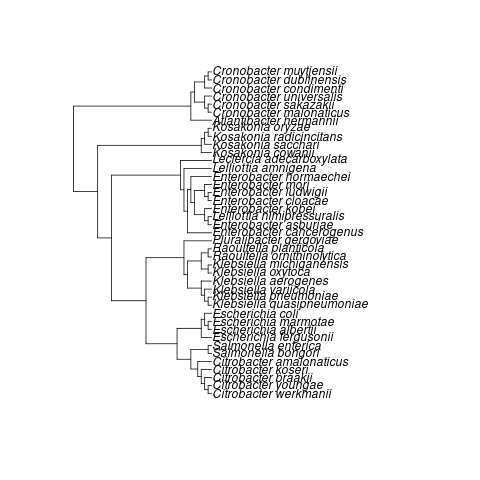

In [15]:
%%R
Enterobacteriaciae_species_tree$tip.label<-gsub("_"," ",Enterobacteriaciae_species_tree$tip.label)
species_microcins$species <- gsub("_"," ",species_microcins$species)
plot(Enterobacteriaciae_species_tree)

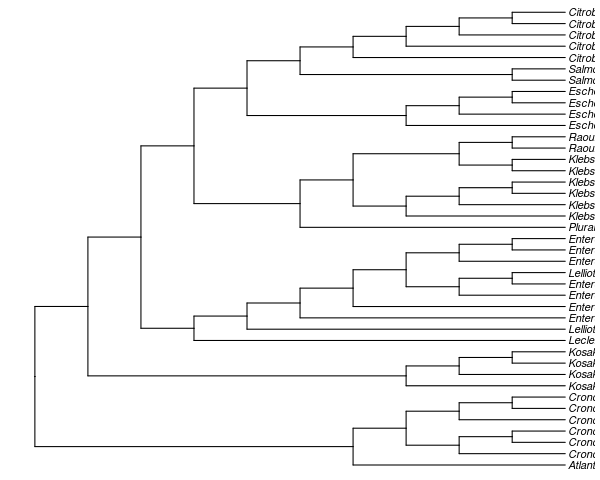

In [16]:
%%R -w 600
species_tree_plot <- ggtree(Enterobacteriaciae_species_tree) +
	geom_tiplab(as_ylab=FALSE, fontface=3)
#	  xlim(0, 0)

species_tree_plot

In [17]:
%%R
species_microcins$clade <- factor(species_microcins$clade, levels = c("Escherichia","Klebsiella","Enterobacter","Kosakonia","Cronobacter"))


In [18]:
%%R
species_microcins %>%
	filter(!(species %in% Enterobacteriaciae_species_tree$tip.label))


# A tibble: 15 × 5
   species                            n_microcins clade      assemblies percen…¹
   <chr>                                    <int> <fct>           <int> <chr>   
 1 Actinomyces marmotae                         5 <NA>                5 1       
 2 Anaerotruncus colihominis                    1 <NA>                1 1       
 3 Brachyspira pilosicoli                       1 <NA>                1 1       
 4 Campylobacter coli                           1 <NA>               40 0.025   
 5 Klebsiella electrica                         2 Klebsiella          2 1       
 6 Klebsiella ornithinolytica                  24 Klebsiella         92 0.26086…
 7 Klebsiella planticola                       19 Klebsiella         44 0.43181…
 8 Klebsiella terrigena                         1 Klebsiella          2 0.5     
 9 Paenarthrobacter nitroguajacolicus           1 <NA>                1 1       
10 Yersinia enterocolitica                      1 <NA>                6 0.16666…
11 <NA>  

In [19]:
%%R
species_microcins_hmmer <- Enterobacteriaceae_best_hits %>%
	filter(component == "microcins.verified") %>%
	filter(hmmerHit == TRUE) %>%
	count(species, accession) %>% 
	count(species, name = "n_microcins") %>%
	full_join(speciesAssemblies) %>%
	mutate(percent_microcin = n_microcins / assemblies) %>%
    mutate(clade = gsub('Citrobacter','Escherichia',clade)) %>%
    mutate(clade = gsub('Salmonella','Escherichia',clade)) %>%
    mutate(clade = gsub('Raoultella','Klebsiella',clade)) %>%
    mutate(clade = gsub('Leclercia','Enterobacter',clade)) %>%
    mutate(clade = gsub('Lelliottia','Enterobacter',clade)) %>%
    mutate(clade = gsub('Atlantibacter','Cronobacter',clade)) %>%
    mutate(clade = gsub('Pluralibacter','Klebsiella',clade))

species_microcins_hmmer$n_microcins[is.na(species_microcins_hmmer$n_microcins)] <- 0
species_microcins_hmmer$percent_microcin[is.na(species_microcins_hmmer$percent_microcin)] <- 0

na.omit(species_microcins_hmmer)

Joining, by = "species"
# A tibble: 53 × 5
   species                   n_microcins clade        assemblies percent_micro…¹
   <chr>                           <dbl> <chr>             <int>           <dbl>
 1 Citrobacter amalonaticus            5 Escherichia          64          0.0781
 2 Citrobacter braakii                 6 Escherichia         126          0.0476
 3 Citrobacter koseri                  2 Escherichia         109          0.0183
 4 Citrobacter werkmanii               3 Escherichia          65          0.0462
 5 Citrobacter youngae                 2 Escherichia          40          0.05  
 6 Cronobacter dublinensis             3 Cronobacter          42          0.0714
 7 Cronobacter malonaticus             3 Cronobacter          62          0.0484
 8 Cronobacter muytjensii              1 Cronobacter           8          0.125 
 9 Enterobacter asburiae               6 Enterobacter        107          0.0561
10 Enterobacter cancerogenus          15 Enterobacter         16  

In [20]:
%%R
#species_microcins_hmmer$species <- gsub("_"," ",species_microcins_hmmer$species)
species_microcins_hmmer$clade <- factor(species_microcins_hmmer$clade, levels = c("Escherichia","Klebsiella","Enterobacter","Kosakonia","Cronobacter"))

species_microcins_hmmer <- na.omit(species_microcins_hmmer)

species_microcins_hmmer <- species_microcins_hmmer %>%
    mutate(species = gsub('Klebsiella planticola','Raoultella planticola',species))%>%
    mutate(species = gsub('Klebsiella ornithinolytica','Raoultella ornithinolytica',species))

species_microcins_hmmer %>% write_csv("data/supplemental/species_microcin_hmmer.csv")

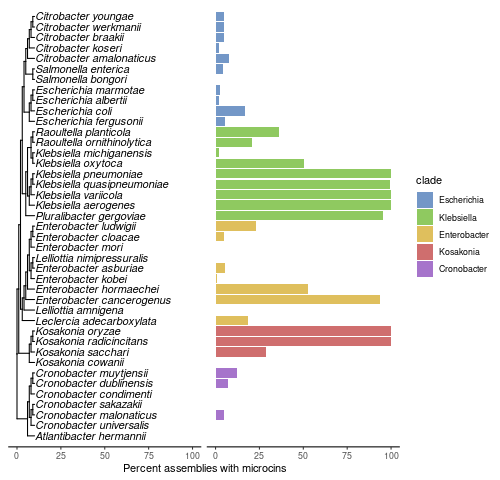

In [21]:
%%R -w 500
# species_tree_plot + 
# geom_facet(panel = "Trait", data = species_microcins, geom = geom_barh, 
#                 aes(x = percent_microcin), width = .6)
species_tree_microcin_plot <- facet_plot(species_tree_plot + 
    xlim(0, 100), 
    panel = "percent microcin", 
    data = species_microcins_hmmer,
    geom = geom_barh,
    mapping = aes(x = percent_microcin*100, fill = clade),
    stat="identity") +
    scale_fill_manual(values=c(
        "#7397c7ff", 
        "#8fc960ff", 
        "#dfbf5dff",
        "#cf6e6eff",
        "#a674cbff")) +
    theme_tree2(strip.background = element_blank(),
    strip.text.x = element_blank(),
         #text = element_text(size = 18)
        ) +
    xlab("Percent assemblies with microcins")

    # xlim(0, 0.1)
species_tree_microcin_plot

#ggsave("plots/07_species_tree_microcin_plot.svg")